# Interpotalion between native surface `fsnative` and `fsLR-32k`

In [202]:
import os
import glob
import requests
import tempfile
import nibabel as nib
import numpy as np
import seaborn as sns

from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres

from brainstat.datasets import fetch_mask, fetch_template_surface

def fetch_surface(surf_name='fsLR-5k.L.inflated.surf.gii', is_surf=True, nibabel=False):

        """
        Fetches a GIFTI surface file from the micapipe GitHub repository.

        Args:
            surf_name (str): The name of the surface file to download (default is 'fsLR-5k.L.inflated.surf.gii').

        Returns:
            nibabel.Giftidata: The loaded surface data from the GIFTI file.
        """

        # Construct the URL for the surface file on GitHub
        url = f'https://raw.githubusercontent.com/MICA-MNI/micapipe/refs/heads/master/surfaces/{surf_name}'

        # Step 1: Download the surface file from the URL
        response = requests.get(url)

        # Ensure the request was successful
        if response.status_code != 200:
            raise Exception(f"Failed to download the surface file: {surf_name} (Status code: {response.status_code})")

        # Step 2: Save the downloaded file in a temporary directory
        with tempfile.NamedTemporaryFile(delete=False, suffix='.surf.gii') as temp_file:
            temp_file.write(response.content)
            temp_file_name = temp_file.name  # Get the temporary file name

        # Step 3: Read the surface data from the downloaded file (assuming GIFTI format)
        if is_surf:
            if nibabel:
                surf_data = nib.load(temp_file_name)
            else:
                surf_data = read_surface(temp_file_name, itype='gii')
        else:
            surf_data = nib.load(temp_file_name).darrays[0].data

        # Step 4: Remove the temporary file after reading (to avoid cluttering disk)
        os.remove(temp_file_name)

        # Return the surface data
        return surf_data
    
def load_qmri_group(qmri='', subjects_list=None, maps='maps'):
    '''
    This function loads and plots the qMRI intensity maps on fsLR32k midthickness
    '''
    # List the files
    files_lh = []
    for path in subjects_list:
        files_lh.extend(glob.glob(f'{path}/{maps}/*_hemi-L_surf-fsLR-32k{qmri}.func.gii'))
    files_rh = []
    for path in subjects_list:
        files_rh.extend(glob.glob(f'{path}/{maps}/*_hemi-R_surf-fsLR-32k{qmri}.func.gii'))    
    
    files_lh = sorted(files_lh)
    files_rh = sorted(files_rh)

    # Load all the thickness data
    Nqmri=np.concatenate((nib.load(files_lh[0]).darrays[0].data, nib.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

    surf_map=np.empty([len(files_lh), Nqmri], dtype=float)
    for i, _ in enumerate(files_lh):
        surf_map[i,:] = np.hstack(np.concatenate((nib.load(files_lh[i]).darrays[0].data, nib.load(files_rh[i]).darrays[0].data), axis=0))

    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)
    
    N = surf_map.shape[0]
    print(f"Numer of {qmri} maps: {N}")               
    return(map_mean,surf_map)

class micapipeName:
    ALLOWED_DIRS = ["anat", "dist", "dwi", "func", "maps", "surf", "parc"]

    def __init__(self, **kwargs):
        self.keys = [
            "sub", "ses", "hemi", "space", "surf", "from", "to", "label", 
            "smooth", "desc", "feat", "Dir"
        ]
        self.values = kwargs

    def build(self):
        parts = []
        dir_part = ""
        feat_part = ""
        for key in self.keys:
            if key in self.values:
                if key == "Dir":
                    suffix = self.values[key]
                    if suffix != "Dir":
                        dir_part = suffix
                elif key == "feat":
                    feat_part = f"_{self.values[key]}"
                elif isinstance(self.values[key], (str, int)):
                    parts.append(f"{key}-{self.values[key]}")
        return f"sub-{self.values['sub']}/ses-{self.values['ses']}/{dir_part}/" + "_".join(parts) + feat_part


class micapipe_fetch:
    def __init__(self, derivatives, sub, ses):
        self.derivatives = derivatives
        self.sub = sub
        self.ses = ses

    def surf(self, hemi="both", space="nativepro", surf="fsnative", label="pial", nibabel=False):
        if hemi not in ["L", "R", "both"]:
            raise ValueError("Invalid hemi value. Choose from 'L', 'R', or 'both'.")

        surfaces = {}

        if hemi in ["L", "both"]:
            file_str_lh = micapipeName(sub=self.sub, ses=self.ses, Dir="surf", hemi="L", space=space, surf=surf, label=label).build()
            
            if nibabel==False:
                surfaces["L"] = read_surface(f"{self.derivatives}/{file_str_lh}.surf.gii", itype='gii')
            else:
                surfaces["L"] = nib.load(f"{self.derivatives}/{file_str_lh}.surf.gii").darrays[0].data
                
        if hemi in ["R", "both"]:
            file_str_rh = micapipeName(sub=self.sub, ses=self.ses, Dir="surf", hemi="R", space=space, surf=surf, label=label).build()
            if nibabel==False:
                surfaces["R"] = read_surface(f"{self.derivatives}/{file_str_rh}.surf.gii", itype='gii')
            else:
                surfaces["R"] = nib.load(f"{self.derivatives}/{file_str_rh}.surf.gii").darrays[0].data

        return surfaces

    def feat(self, hemi="both", surf="fsnative", label="pial", feat=None, concatenate=False):
        if hemi not in ["L", "R", "both"]:
            raise ValueError("Invalid hemi value. Choose from 'L', 'R', or 'both'.")

        if feat is None:
            raise ValueError("Feature (feat) must be specified.")

        features = {}

        for hemisphere in ["L", "R"]:
            if hemi in [hemisphere, "both"]:
                kwargs = {
                    "sub": self.sub,
                    "ses": self.ses,
                    "Dir": "maps",
                    "hemi": hemisphere,
                    "surf": surf,
                    "label": "thickness" if feat == "thickness" else label
                }
                if feat != "thickness":
                    kwargs["feat"] = feat

                file_str = micapipeName(**kwargs).build()
                features[hemisphere] = nib.load(f"{self.derivatives}/{file_str}.func.gii").darrays[0].data

        if concatenate:
            feat_cat = np.concatenate((features.get("L", []), features.get("R", [])), axis=0)
            return feat_cat
        else:
            return features

In [203]:
from brainspace.plotting.surface_plotting import plot_surf
from typing import List, Union, Tuple

# Functions for plotting
def plot_surfs(
    surfaces,
    values: List[np.ndarray],
    views: Union[List[str], None] = None,
    size: Union[int, Tuple[int, int], None] = None,
    zoom: Union[float, List[float]] = 1.75,
    color_bar="bottom",
    share="both",
    color_range=(-2, 2),
    cmap="rocket",
    transparent_bg=False,
    **kwargs,
):
    """
    surfaces = [hip_mid_l, hip_unf_l, hip_unf_r, hip_mid_r]  Can be 1 or more
    views = ['dorsal', 'lateral', 'lateral', 'dorsal'] Can be 1 or more
    """

    # Append values to surfaces
    my_surfs = {}
    array_names = []
    for i, surf in enumerate(surfaces):
        name = f"surf{i + 1}"
        surf.append_array(values[i], name=name)

        my_surfs[name] = surf
        array_names.append(name)

    # Set the layout as the list of keys from my_surfs
    layout = [list(my_surfs.keys())]

    if size is None:
        size = (200 * len(surfaces), 350)

    return plot_surf(
        my_surfs,
        layout,
        array_name=array_names,
        view=views,
        color_bar=color_bar,
        color_range=color_range,
        share=share,
        cmap=cmap,
        zoom=zoom,
        size=size,
        transparent_bg=transparent_bg,
        **kwargs,
    )

In [230]:
# Load fsLR-32k surface
surf_lh = fetch_surface('fsLR-32k.L.inflated.surf.gii')
surf_rh = fetch_surface('fsLR-32k.R.inflated.surf.gii')

# fsLR-32k middle wall mask
fslr32k_mask = fetch_mask("fslr32k")

# Derivatives directory
derivatives = "/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0"
sub = "PNC019"
ses = "01"
label = "midthickness"
surf = "fsnative"
space = "nativepro"
feat = "thickness"

# micapipe fetcher
fetcher = micapipe_fetch(derivatives=derivatives, sub=sub, ses=ses)

# Load subject native surface
surf_nat = fetcher.surf(hemi="both", space="nativepro", surf="fsnative", label=label)

# Load subject native surface
surf_32k = fetcher.surf(hemi="both", space="nativepro", surf="fsLR-32k", label=label)

# Load subject's data on fsnative
feat_nat = fetcher.feat(surf="fsnative", feat="thickness", concatenate=False)

# Load subject's data on fsLR-32k
feat_32k = fetcher.feat(surf="fsLR-32k", feat="thickness", concatenate=False)


In [75]:
# Subjects
subs_pni = ['PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC011', 'PNC012', 
    'PNC013', 'PNC014', 'PNC015', 'PNC016', 'PNC018', 'PNC019', 
    'PNC020', 'PNC021', 'PNC022', 'PNC023', 'PNC024', 'PNC025', 
    'PNC026', 'PNC027']


# For PNI subjects
dirs_pni = []
for sub in subs_pni:
    dirs_pni.extend(glob.glob(f'/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-{sub}/ses-*'))

# Load group data in fsLR-32k (thickness)
feat_mean,_ = load_qmri_group("_label-thickness", subjects_list=dirs_pni, maps="maps")


Numer of _label-thickness maps: 66


## Native subject surface

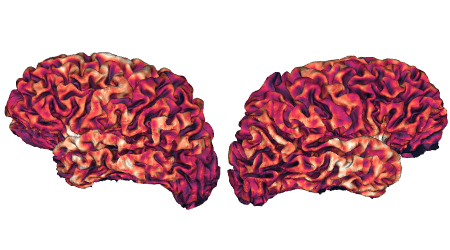

In [231]:
# Plot the group T1map intensitites
#crange=(np.quantile(feat_32k[fslr32k_mask], 0.01), np.quantile(feat_32k[fslr32k_mask], 0.975))
crange=(1.5,4)

# Plot the native surface
plot_surfs( surfaces=[surf_nat['L'], surf_nat['R']],
    values=[feat_nat['L'],feat_nat['R']],
    views=["lateral", "medial"],
    label_text={"top": ["","",]},
    share="both",
    zoom=1.25,
    size=(450, 250),
    color_bar=None,
    color_range=crange,
    scale=1,
    transparent_bg=False,
    embed_nb=True, 
    interactive=False  )

## fsLR-32k standard surface: Subject

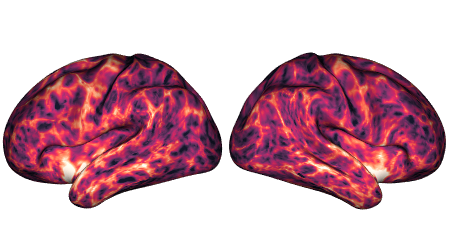

In [208]:
# Plot the native surface
plot_surfs( surfaces=[surf_lh, surf_rh],
    values=[feat_32k['L'],feat_32k['R']],
    views=["lateral", "medial"],
    label_text={"top": ["","",]},
    share="both",
    zoom=1.25,
    size=(450, 250),
    color_bar=None,
    color_range=crange,
    scale=1,
    transparent_bg=False,
    embed_nb=True, 
    interactive=False  )

## fsLR-32k standard surface: Group mean

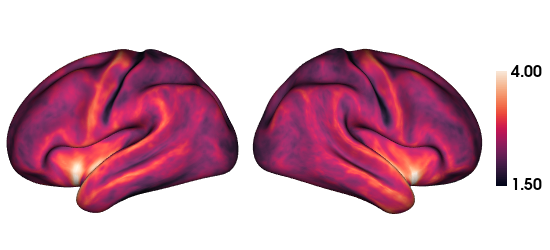

In [124]:
# Plot the native surface
plot_surfs( surfaces=[surf_lh, surf_rh],
    values=[feat_mean[0:32492],feat_mean[32492:64984]],
    views=["lateral", "medial"],
    label_text={"top": ["","",]},
    share="both",
    zoom=1.25,
    size=(550, 250),
    color_bar='right',
    color_range=crange,
    scale=1,
    transparent_bg=False,
    embed_nb=True, 
    interactive=False  )


## Histograms overlayed

In [187]:
import matplotlib.pyplot as plt
from matplotlib import cm

def create_overlaid_histograms(feat_mean, feat_32k, alpha_mean=0.3, alpha_32k=1.0, 
                               bins=100, cmap='viridis', xlabel='', ylabel='Frequency', 
                               title='', Range=None, size=(4, 3)):
    """
    Creates overlaid histograms for two variables: feat_mean and feat_32k.

    Parameters:
        feat_mean (array-like): Data for the first histogram (background).
        feat_32k (array-like): Data for the second histogram (foreground).
        alpha_mean (float): Transparency for feat_mean histogram.
        alpha_32k (float): Transparency for feat_32k histogram.
        bins (int): Number of bins for the histograms.
        cmap (str): Colormap for the histograms.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
        Range (tuple): Range for the histograms. Defaults to the range of feat_mean.
        size (tuple): Size of the figure.
    """
    plt.figure(figsize=size)

    if Range is None:
        Range = (feat_mean.min(), feat_mean.max())
    elif not isinstance(Range, tuple) or len(Range) != 2:
        raise ValueError("Range must be a tuple with two elements (min, max).")

    # Plot histogram for feat_mean (background)
    n_mean, bins_mean, _ = plt.hist(feat_mean, bins=bins, alpha=0)  # Get bins without plotting
    bin_centers_mean = (bins_mean[:-1] + bins_mean[1:]) / 2
    plt.bar(bin_centers_mean, n_mean, width=np.diff(bins_mean), color="#D6DBDF", alpha=alpha_mean, label='feat_mean')

    # Plot histogram for feat_32k (foreground)
    n_32k, bins_32k, _ = plt.hist(feat_32k, bins=bins, alpha=0)  # Get bins without plotting
    bin_centers_32k = (bins_32k[:-1] + bins_32k[1:]) / 2
    colormap_32k = cm.get_cmap(cmap)
    colored_bins_32k = colormap_32k(np.interp(bin_centers_32k, [Range[0], Range[1]], [0, 1]))
    plt.bar(bin_centers_32k, n_32k, width=np.diff(bins_32k), color=colored_bins_32k, alpha=alpha_32k, label='feat_32k')

    # Add labels, title, and legend
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.title(title, fontsize=12)

    # Remove the outer box line
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Set the grid on the back
    plt.gca().set_axisbelow(True)
    plt.grid(color='#EBEDEF', linestyle='-')  # Regular line style and custom color

    plt.show()
    
    

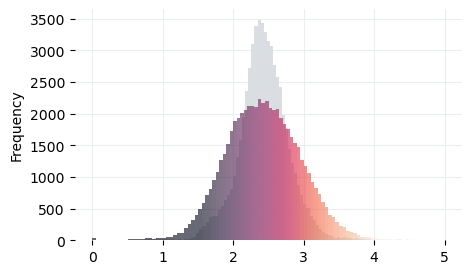

In [184]:

feat_32k_cat = np.concatenate((feat_32k['L'], feat_32k['R']), axis=0)

create_overlaid_histograms(feat_mean[fslr32k_mask==True], feat_32k_cat[fslr32k_mask==True], 
                           alpha_mean=0.9, 
                           alpha_32k=0.6, 
                           bins=100, 
                           cmap='rocket', 
                           xlabel='', 
                           ylabel='Frequency', 
                           title='',
                          Range=crange)


# Interpolation

In [232]:
from scipy.interpolate import griddata

def metric_resample(from_metric, from_surf, to_surf, method='nearest'):
    """
    Resample a metric from one surface to another.

    Parameters:
        from_metric (array-like): Metric data on the original surface.
        from_surf (nibabel.GiftiImage): Original surface (source).
        to_surf (nibabel.GiftiImage): Target surface (destination).
        method (str): Interpolation method ('nearest', 'linear', 'cubic').

    Returns:
        to_metric (array-like): Resampled metric data on the target surface.
    """
    # Validate inputs
    if from_surf.shape[1] != 3 or to_surf.shape[1] != 3:
        raise ValueError("Surface coordinates must be 3D.")

    if len(from_metric) != from_surf.shape[0]:
        raise ValueError("Length of from_metric must match the number of vertices in from_surf.")

    # Both surfaces MUST be on the same space and be the same label.
    # Otherwise, the interpolation will likely fail.
    # Example:
    # from: space-nativepro_surf-fsnative_label-midthickness
    # to: space-nativepro_surf-fsLR-32k_label-midthickness

    # Interpolate the metric data from the source surface to the target surface
    to_metric = griddata(from_surf, from_metric, to_surf, method=method, fill_value=np.nan)

    return to_metric

In [235]:
# Load subject native surface with NIBABEL
surf_nat_nib = fetcher.surf(hemi="both", space="nativepro", surf="fsnative", label=label, nibabel=True)

# Load subject native surface with NIBABEL
surf_32k_nib = fetcher.surf(hemi="both", space="nativepro", surf="fsLR-32k", label=label, nibabel=True)

# Resample the data
feat_nat_res_lh = metric_resample(feat_32k['L'], surf_32k_nib['L'], surf_nat_nib['L'])
feat_nat_res_rh = metric_resample(feat_32k['R'], surf_32k_nib['R'], surf_nat_nib['R'])

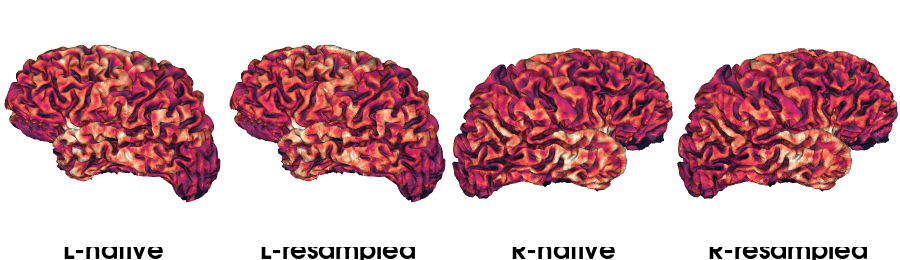

In [269]:
# Plot the group T1map intensitites
#crange=(np.quantile(feat_32k[fslr32k_mask], 0.01), np.quantile(feat_32k[fslr32k_mask], 0.975))
crange=(1.5,4)

# Plot the native surface
plot_surfs( surfaces=[surf_nat['L'], surf_nat['L'], surf_nat['R'], surf_nat['R']],
    values=[feat_nat['L'],feat_nat_res_lh, feat_nat['R'],feat_nat_res_rh],
    views=["lateral", "lateral", "medial", "medial"],
    label_text={"bottom": ["L-native","L-resampled","R-native","R-resampled"]},
    share="both",
    zoom=1.25,
    size=(900, 260),
    color_bar=None,
    color_range=crange,
    scale=1,
    transparent_bg=True,
    embed_nb=True, 
    interactive=False  )

In [260]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_color_correlation(Xval, Yval,
                           Ylab='Y-label', Xlab='X-label', col='rocket', 
                           linecol='darkred', barlab='Colored correlation',
                           crange=None, figsize=(7, 6)):
    """
    Plots a scatterplot with LOWESS regression line and a colorbar.

    Parameters:
        Xval (array-like): Independent variable for the scatterplot.
        Yval (array-like): Dependent variable for the scatterplot.
        Ylab (str): Label for the y-axis.
        Xlab (str): Label for the x-axis.
        col (str): Colormap for the scatterplot.
        linecol (str): Color for the LOWESS regression line.
        barlab (str): Label for the colorbar.
        crange (tuple): Range for colormap normalization (vmin, vcenter, vmax).
    """
    # Create a 1x1 layout for the plot
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Define the colormap normalization
    if crange is None:
        norm = TwoSlopeNorm(vmin=np.min(Yval), vcenter=np.mean(Yval), vmax=np.max(Yval))
    else:
        if not isinstance(crange, tuple) or len(crange) != 3:
            raise ValueError("crange must be a tuple with three elements (vmin, vcenter, vmax).")
        norm = TwoSlopeNorm(vmin=crange[0], vcenter=crange[1], vmax=crange[2])

    # Compute correlation and p-value
    correlation, p_value = spearmanr(Xval, Yval)

    # Scatterplot
    sns.scatterplot(x=Xval, y=Yval, ax=ax, 
                    hue=Yval, palette=col, alpha=0.5, legend=None, hue_norm=norm)

    # LOWESS regression line
    lowess_result = lowess(Yval, Xval, frac=0.3)
    ax.plot(lowess_result[:, 0], lowess_result[:, 1], color=linecol, alpha=0.95)

    # Set titles and labels
    ax.set_title(f'rho: {correlation:.2f}\npval: {p_value:.8f}')
    ax.set_xlabel(Xlab)
    ax.set_ylabel(Ylab)

    # Add colorbar outside the plot area
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=col, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cax, orientation='vertical', label=barlab)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
    

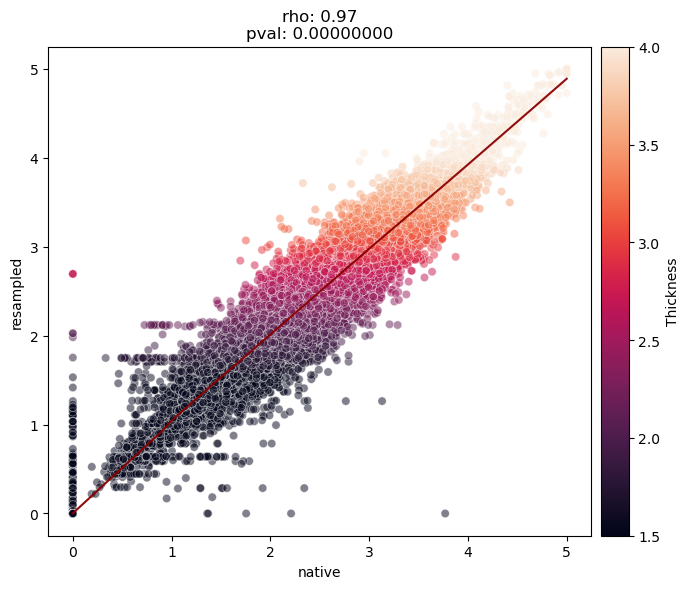

In [268]:
plot_color_correlation(Xval=feat_nat['L'], Yval=feat_nat_res_lh, 
                       Xlab='native', Ylab='resampled', 
                       barlab='Thickness', col='rocket', 
                       linecol='darkred', figsize=(7, 6), 
                       crange=(crange[0], 2.75, crange[1]))